# Feature extraction using VGG16

In [1]:
# import packages - basics 
import pandas as pd
import os
import numpy as np
import cv2
# tf tools
import tensorflow as tf
# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10
# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD
#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
# for plotting
import matplotlib.pyplot as plt

2023-05-06 11:04:09.095193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plotting function (from last week)

In [2]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Initialize the model

In [3]:
# load the model
model = VGG16()

553467096/553467096 [==============================] - 14s 0us/step


## Loading in the data

In [4]:
# load in the test data
filename = os.path.join("..", "data", "test_data.json")
test_data = pd.read_json(filename, lines=True)
# load the train data
filename2 = os.path.join("..", "data", "train_data.json")
train_data = pd.read_json(filename2, lines=True)
# load the validation data
filename3 = os.path.join("..", "data", "val_data.json")
val_data = pd.read_json(filename3, lines=True)

In [5]:
val_data.head()

,image_url,image_path,brand,product_title,class_label,color
0,https://m.media-amazon.com/images/I/81LOPbFPiQ...,images/val/0.jpeg,Generic,Women's Khadi Cotton Saree With Blouse Piece (...,saree,NaN
1,https://m.media-amazon.com/images/I/81Q8Oktw4s...,images/val/1.jpeg,Yashvi Designer,Women's Net Saree With Unstitched Blouse Piece,saree,NaN
2,https://m.media-amazon.com/images/I/613S1YGCmo...,images/val/2.jpeg,Aarrah,Georgette Strip Print Saree[S_SHIKHA30021SR02_...,saree,NaN
3,https://m.media-amazon.com/images/I/819budhQl1...,images/val/3.jpeg,MIMOSA,Women's Patola Style Art Silk Saree (Green),saree,NaN
4,https://m.media-amazon.com/images/I/61cAZ94ZQV...,images/val/4.jpeg,Generic,Women's Pure Hand Block Patola Printed Cotton ...,saree,NaN


In [5]:
labelNames = test_data['class_label'].unique()

In [6]:
# these are all the same so can be done the same below 
train_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

val_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [9]:
BATCH_SIZE = 32
TARGET_SIZE = (224,224)

# Split the data into categories
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    directory="../data/",
    x_col='image_path',
    y_col='class_label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)

# Split the data into categories
val_images = val_generator.flow_from_dataframe(
    dataframe=val_data,
    directory="../data/",
    x_col='image_path',
    y_col='class_label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    directory="../data/",
    x_col='image_path',
    y_col='class_label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
)

Found 11263 validated image filenames belonging to 15 classes.
Found 7500 validated image filenames belonging to 15 classes.
Found 7500 validated image filenames belonging to 15 classes.


/home/coder/.local/lib/python3.9/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 79903 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


__Load VGG16 *without* the classification layers__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```

We also redefine the input shape, to work better with our cifar10 data.

In [10]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 2s 0us/step


Called include_top because think of networks working from the bottom up. Remember interactive visualization, starting with data/image and then working it's way up the layeres of the neural network.

__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

In [11]:
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

Means we're freezing the weights and not retraining the model

In [12]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [13]:
tf.keras.backend.clear_session()

In [14]:
# add new classifier layers - another way of adding layers - different than previous syntax we've seen before 
flat1 = Flatten()(model.layers[-1].output) # syntax here is a = (newlayer) (oldlayer)
class1 = Dense(128, activation='relu')(flat1) # b = (newlayer)(a)
output = Dense(15, activation='softmax')(class1) # c = new(b)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Can now compare with above and can see we added almost 67,000  trainable parameters 

__Compile__

We're going to be using a more sophisticated optimization algorithm, which you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay).

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, 
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

In [16]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

__Train__

In [21]:
batch_size = 64
H = model.fit(train_images,
            batch_size=batch_size,
            validation_data=val_images,
            steps_per_epoch=train_images.samples // batch_size,
            validation_steps=val_images.samples // batch_size,
            epochs=10,
            verbose=1)

Epoch 1/10


2023-05-05 16:09:07.959602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


175/175 [==============================] - ETA: 0s - loss: 0.7837 - accuracy: 0.7464

2023-05-05 16:15:47.061127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


175/175 [==============================] - 646s 4s/step - loss: 0.7837 - accuracy: 0.7464 - val_loss: 0.9416 - val_accuracy: 0.6987
Epoch 2/10
175/175 [==============================] - 435s 2s/step - loss: 0.7290 - accuracy: 0.7600 - val_loss: 0.8401 - val_accuracy: 0.7366
Epoch 3/10
175/175 [==============================] - 236s 1s/step - loss: 0.6536 - accuracy: 0.7925 - val_loss: 0.8335 - val_accuracy: 0.7412
Epoch 4/10
175/175 [==============================] - 156s 894ms/step - loss: 0.6003 - accuracy: 0.8073 - val_loss: 0.8513 - val_accuracy: 0.7441
Epoch 5/10
175/175 [==============================] - 136s 779ms/step - loss: 0.5869 - accuracy: 0.8118 - val_loss: 0.8450 - val_accuracy: 0.7332
Epoch 6/10
175/175 [==============================] - 132s 754ms/step - loss: 0.5455 - accuracy: 0.8216 - val_loss: 0.8185 - val_accuracy: 0.7511
Epoch 7/10
175/175 [==============================] - 131s 747ms/step - loss: 0.5159 - accuracy: 0.8325 - val_loss: 0.8408 - val_accuracy: 0.730

__Evaluate__

/tmp/ipykernel_623/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


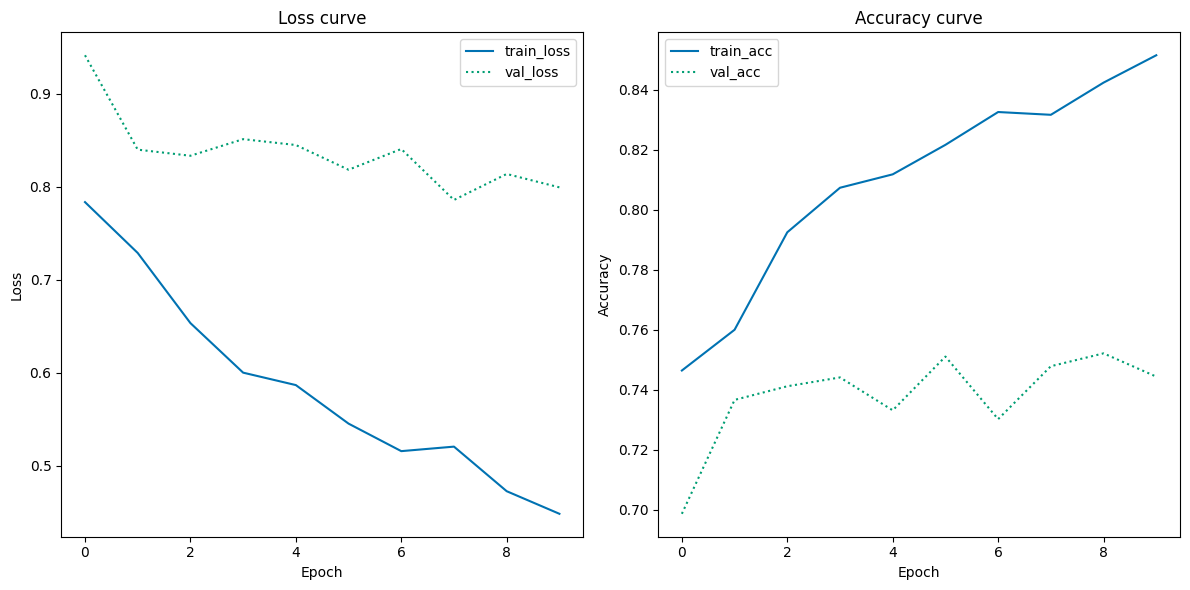

In [23]:
# the number is for the number of epochs 
plot_history(H, 10)

Might indicate validation data isn't representative enough but would be happy with this. Could be trained a little longer, 1-2 epochs. 

In [24]:
predictions = model.predict(test_images, batch_size=128)
print(classification_report(test_images.classes,
                            predictions.argmax(axis=1),
                            target_names=labelNames))


2023-05-05 17:18:25.432299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 504s 2s/step
                      precision    recall  f1-score   support

               saree       0.90      0.94      0.92       500
              blouse       0.83      0.42      0.56       500
         dhoti_pants       0.70      0.63      0.67       500
            dupattas       0.67      0.43      0.52       500
               gowns       0.71      0.88      0.79       500
           kurta_men       0.53      0.84      0.65       500
leggings_and_salwars       0.91      0.82      0.86       500
             lehenga       0.86      0.82      0.84       500
         mojaris_men       0.83      0.84      0.83       500
       mojaris_women       0.85      0.87      0.86       500
       nehru_jackets       0.91      0.55      0.69       500
            palazzos       0.90      0.82      0.86       500
          petticoats       0.69      0.90      0.78       500
           sherwanis       0.87      0.70      0.78       500
         wome

## Using data augmentation

__Reload model__

In [7]:
del model
tf.keras.backend.clear_session()

In [8]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1)            ## take the outputs (image embeddings) and normalize them 
class1 = Dense(256,                         ### only difference is adding this extra hidden layer 
               activation='relu')(bn)
class2 = Dense(128, 
               activation='relu')(class1)
output = Dense(15, 
               activation='softmax')(class2)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [9]:
# flip along x axis (mirror image)
datagen = ImageDataGenerator(horizontal_flip=True, 
                             rotation_range=20, # how many degrees to rotate it 
                            preprocessing_function = preprocess_input)

We're choosing to generate data on the fly, rather than save it to a folder. This validation split labels some as training and some as validation which we use below when training. 

__Train__

In [10]:
BATCH_SIZE = 32
TARGET_SIZE = (224,224)

# Split the data into categories
train_images = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory="../data/",
    x_col='image_path',
    y_col='class_label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)

# Split the data into categories
val_images = datagen.flow_from_dataframe(
    dataframe=val_data,
    directory="../data/",
    x_col='image_path',
    y_col='class_label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)


test_images = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory="../data/",
    x_col='image_path',
    y_col='class_label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
)


Found 11263 validated image filenames belonging to 15 classes.
Found 7500 validated image filenames belonging to 15 classes.
Found 7500 validated image filenames belonging to 15 classes.


/home/coder/.local/lib/python3.9/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 79903 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [11]:
batch_size = 64
H = model.fit(train_images,
            batch_size=batch_size,
            validation_data=val_images,
            steps_per_epoch=train_images.samples // batch_size,
            validation_steps=val_images.samples // batch_size,
            epochs=10,
            verbose=1)


Epoch 1/10


2023-05-06 11:05:36.232260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


175/175 [==============================] - ETA: 0s - loss: 2.0543 - accuracy: 0.3774

2023-05-06 11:13:28.624086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


175/175 [==============================] - 720s 4s/step - loss: 2.0543 - accuracy: 0.3774 - val_loss: 1.6969 - val_accuracy: 0.4613
Epoch 2/10
175/175 [==============================] - 430s 2s/step - loss: 1.3334 - accuracy: 0.5929 - val_loss: 1.2874 - val_accuracy: 0.5988
Epoch 3/10
175/175 [==============================] - 297s 2s/step - loss: 1.0863 - accuracy: 0.6584 - val_loss: 1.0875 - val_accuracy: 0.6418
Epoch 4/10
175/175 [==============================] - 232s 1s/step - loss: 0.9656 - accuracy: 0.6893 - val_loss: 1.0051 - val_accuracy: 0.6661
Epoch 5/10
175/175 [==============================] - 204s 1s/step - loss: 0.8682 - accuracy: 0.7227 - val_loss: 0.9556 - val_accuracy: 0.6880
Epoch 6/10
175/175 [==============================] - 187s 1s/step - loss: 0.7961 - accuracy: 0.7414 - val_loss: 0.9094 - val_accuracy: 0.7030
Epoch 7/10
175/175 [==============================] - 181s 1s/step - loss: 0.7829 - accuracy: 0.7471 - val_loss: 0.8849 - val_accuracy: 0.7126
Epoch 8/10

__Inspect__

/tmp/ipykernel_664/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


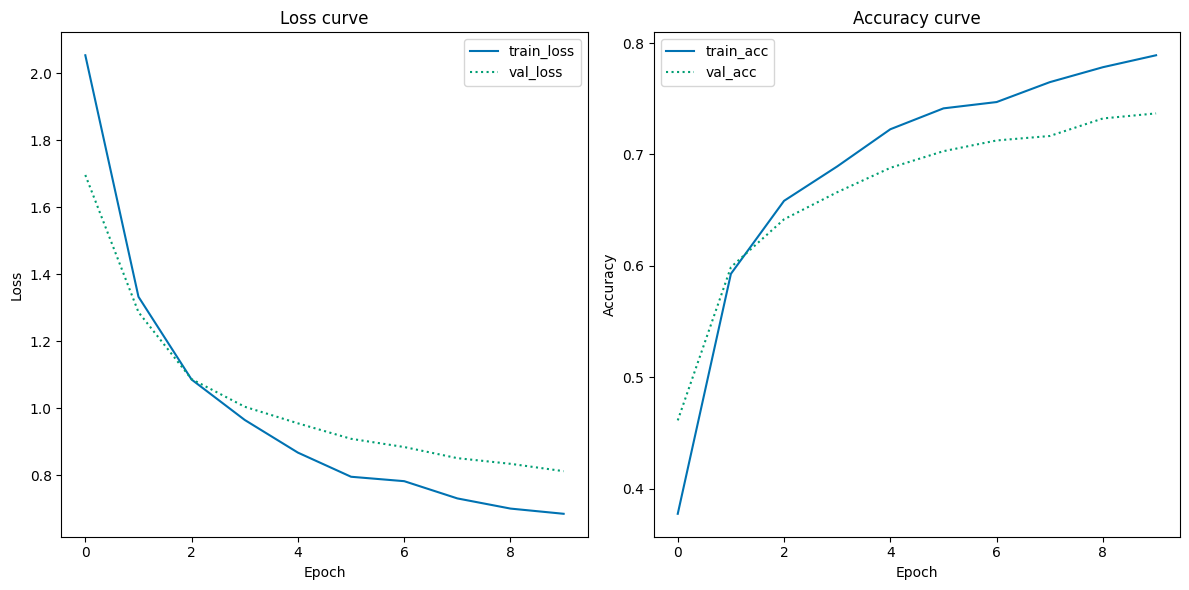

In [12]:
plot_history(H, 10)

Might indicate overfitting but otherwise looks good. 

__Evaluate__

In [13]:
predictions = model.predict(test_images, batch_size=128)
print(classification_report(test_images.classes,
                            predictions.argmax(axis=1),
                            target_names=labelNames))

2023-05-06 11:52:17.855005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 633s 3s/step
                      precision    recall  f1-score   support

               saree       0.88      0.94      0.91       500
              blouse       0.75      0.47      0.57       500
         dhoti_pants       0.65      0.61      0.63       500
            dupattas       0.70      0.35      0.47       500
               gowns       0.71      0.85      0.77       500
           kurta_men       0.62      0.76      0.68       500
leggings_and_salwars       0.83      0.88      0.86       500
             lehenga       0.84      0.82      0.83       500
         mojaris_men       0.83      0.81      0.82       500
       mojaris_women       0.89      0.83      0.86       500
       nehru_jackets       0.83      0.74      0.78       500
            palazzos       0.80      0.79      0.79       500
          petticoats       0.71      0.85      0.77       500
           sherwanis       0.82      0.73      0.77       500
         wome

Have increased f1/accuracy by 5% by adding the batch normalization, adding one hidden layer and some minor data augmentation. Cats are the only category that is struggling. 

In [ ]:
# classification report 
label_names = list(test_images.class_indicies.keys())
report = classification_report(test_images.classes,
                                predictions.argmax(axis=1),
                                target_names = label_names)